In [27]:
# import necessary packages
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [28]:
# laod data
dataset = pd.read_csv('Data/temperature_prediction.csv', parse_dates = True, index_col = 'Time')
# Drop the occupant column
dataset.drop('Occupancy', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['Airflow', 'Discharge_air_temperature', 'CO2', 'Zone_temp']
dataset.index.name = 'Time'
# replace all NA values with 0
dataset['Zone_temp'].fillna(0, inplace=True)
dataset = dataset[['Zone_temp', 'Airflow', 'Discharge_air_temperature', 'CO2']]
dataset.head()

,Zone_temp,Airflow,Discharge_air_temperature,CO2
Time,,,,
2017-06-08 00:00:10,74.300003,14,62.700001,323
2017-06-08 00:00:40,74.300003,14,62.500000,325
2017-06-08 00:01:10,74.300003,14,62.400002,326
2017-06-08 00:01:40,74.300003,14,62.400002,324
2017-06-08 00:02:10,74.300003,14,62.400002,325


In [29]:
dataset.to_csv('temperature_data.csv')

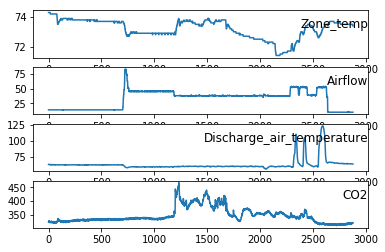

In [30]:
# reload the preprocessed dataset
dataset = pd.read_csv('temperature_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [31]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [32]:
# integer encode direction
encoder = LabelEncoder()
values[:, 3] = encoder.fit_transform(values[:, 3])
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5, 6, 7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var1(t)
1        1.0   0.054795   0.105498   0.092857      1.0
2        1.0   0.054795   0.102526   0.107143      1.0
3        1.0   0.054795   0.101040   0.114286      1.0
4        1.0   0.054795   0.101040   0.100000      1.0
5        1.0   0.054795   0.101040   0.107143      1.0


In [33]:
# split into train and test sets
values = reframed.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into inputs and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# define the input dimension for neural networks
lags = 4

(2000, 1, 4) (2000,) (877, 1, 4) (877,)


In [34]:
# design lstm network
model_lstm = Sequential()
model_lstm.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mae', optimizer='adam')
# design neural network
model_nn = Sequential()
model_nn.add(Dense(10, input_dim = lags, activation='relu'))
model_nn.add(Dense(1))
model_nn.compile(loss='mae', optimizer='adam')
X_1 = train_X.reshape((train_X.shape[0], train_X.shape[2]))
X_2 = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [35]:
# fit lstm network
history_lstm = model_lstm.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# fit nn
train_X_nn = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X_nn = test_X.reshape((test_X.shape[0], test_X.shape[2]))
history_nn = model_nn.fit(train_X_nn, train_y, epochs=100, batch_size=72, validation_data=(test_X_nn, test_y), verbose=2)

Train on 2000 samples, validate on 877 samples
Epoch 1/100
 - 2s - loss: 0.5045 - val_loss: 0.2190
Epoch 2/100
 - 0s - loss: 0.1799 - val_loss: 0.2158
Epoch 3/100
 - 0s - loss: 0.1340 - val_loss: 0.1819
Epoch 4/100
 - 0s - loss: 0.1156 - val_loss: 0.1713
Epoch 5/100
 - 0s - loss: 0.0998 - val_loss: 0.1413
Epoch 6/100
 - 0s - loss: 0.0861 - val_loss: 0.1488
Epoch 7/100
 - 0s - loss: 0.0456 - val_loss: 0.1241
Epoch 8/100
 - 0s - loss: 0.0399 - val_loss: 0.1189
Epoch 9/100
 - 0s - loss: 0.0305 - val_loss: 0.1117
Epoch 10/100
 - 0s - loss: 0.0297 - val_loss: 0.1107
Epoch 11/100
 - 0s - loss: 0.0306 - val_loss: 0.1169
Epoch 12/100
 - 0s - loss: 0.0338 - val_loss: 0.1394
Epoch 13/100
 - 0s - loss: 0.0274 - val_loss: 0.1260
Epoch 14/100
 - 0s - loss: 0.0261 - val_loss: 0.1331
Epoch 15/100
 - 0s - loss: 0.0255 - val_loss: 0.1265
Epoch 16/100
 - 0s - loss: 0.0249 - val_loss: 0.1185
Epoch 17/100
 - 0s - loss: 0.0309 - val_loss: 0.1034
Epoch 18/100
 - 0s - loss: 0.0304 - val_loss: 0.0917
Epoch 19

 - 0s - loss: 0.0077 - val_loss: 0.0640
Epoch 55/100
 - 0s - loss: 0.0071 - val_loss: 0.0632
Epoch 56/100
 - 0s - loss: 0.0067 - val_loss: 0.0622
Epoch 57/100
 - 0s - loss: 0.0064 - val_loss: 0.0610
Epoch 58/100
 - 0s - loss: 0.0061 - val_loss: 0.0607
Epoch 59/100
 - 0s - loss: 0.0063 - val_loss: 0.0610
Epoch 60/100
 - 0s - loss: 0.0058 - val_loss: 0.0601
Epoch 61/100
 - 0s - loss: 0.0056 - val_loss: 0.0594
Epoch 62/100
 - 0s - loss: 0.0054 - val_loss: 0.0596
Epoch 63/100
 - 0s - loss: 0.0054 - val_loss: 0.0604
Epoch 64/100
 - 0s - loss: 0.0052 - val_loss: 0.0598
Epoch 65/100
 - 0s - loss: 0.0053 - val_loss: 0.0592
Epoch 66/100
 - 0s - loss: 0.0050 - val_loss: 0.0594
Epoch 67/100
 - 0s - loss: 0.0052 - val_loss: 0.0580
Epoch 68/100
 - 0s - loss: 0.0052 - val_loss: 0.0593
Epoch 69/100
 - 0s - loss: 0.0051 - val_loss: 0.0583
Epoch 70/100
 - 0s - loss: 0.0049 - val_loss: 0.0581
Epoch 71/100
 - 0s - loss: 0.0049 - val_loss: 0.0578
Epoch 72/100
 - 0s - loss: 0.0048 - val_loss: 0.0574
Epoch 

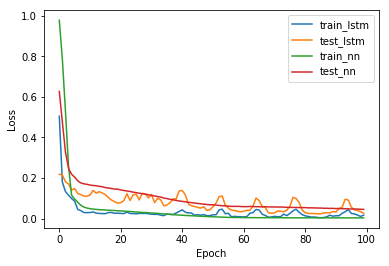

In [36]:
# plot history
plt.plot(history_lstm.history['loss'], label='train_lstm')
plt.plot(history_lstm.history['val_loss'], label='test_lstm')
plt.plot(history_nn.history['loss'], label='train_nn')
plt.plot(history_nn.history['val_loss'], label='test_nn')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
# make a prediction
print(test_X.shape)
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
yhat_lstm = model_lstm.predict(test_X)
yhat_nn = model_nn.predict(test_X_nn)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

(877, 1, 4)


In [42]:
# invert scaling for forecast
inv_yhat_lstm = np.concatenate((yhat_lstm, test_X[:, 1:]), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,0]
inv_yhat_nn = np.concatenate((yhat_nn, test_X_nn[:, 1:]), axis=1)
inv_yhat_nn = scaler.inverse_transform(inv_yhat_nn)
inv_yhat_nn = inv_yhat_nn[:,0]

In [43]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [47]:
# calculate RMSE
import math
from sklearn.metrics import mean_squared_error
rmse_lstm = math.sqrt(mean_squared_error(inv_y, inv_yhat_lstm))
rmse_nn = math.sqrt(mean_squared_error(inv_y, inv_yhat_nn))
#rmse_arimax = sqrt(mean_squared_error(inv_y, arimax_results))
print('Test LSTM_RMSE: %.3f' % rmse_lstm)
print('Test Neural Networks RMSE: %.3f' % rmse_nn)

Test LSTM_RMSE: 0.109
Test Neural Networks RMSE: 0.226


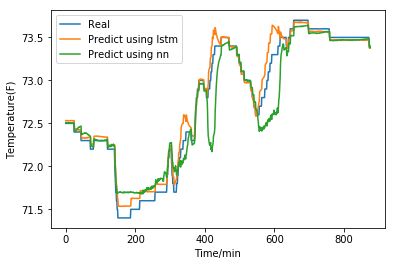

In [50]:
plt.plot(inv_y, label='Real')
plt.plot(inv_yhat_lstm, label='Predict using lstm')
plt.plot(inv_yhat_nn, label='Predict using nn')
plt.xlabel('Time/min')
plt.ylabel('Temperature(F)')
plt.legend()
plt.show()